# 機械学習アラカルト

### Q1. 勾配法（最急降下法）
下記コードを実行後に得られる``X``および``y``には，$y=3.14x-1.59$で表される直線上の点にノイズを加えたデータが納められている．このデータが$y=ax+b$という直線から得られたと仮定する．最急降下法を実装し，パラメータ``a``および``b``を求めよ．

なお，パラメータ更新ステップの学習率は$10^{-4}$とせよ．また，終了条件は以下とせよ．
* パラメータ更新回数が一定回数以上になった時，もしくは
* パラメータの更新量の絶対値が$10^{-8}$以下になった時

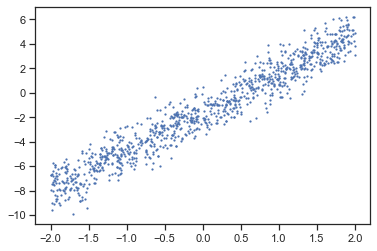

In [1]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style('ticks')
%matplotlib inline


def f(x):
    return  3.14 * x - 1.59

data_num = 1000
X = np.random.uniform(-2, 2, data_num).reshape(-1, 1)
y = f(X) + np.random.normal(0, 1, data_num).reshape(-1, 1)

sns.scatterplot(x=X[:, 0], y=y[:, 0], linewidth=0, s=5)
plt.show()

In [2]:
from tqdm.notebook import tqdm

In [3]:
def loss_func(X, y, w):
    return np.apply_along_axis(sum, 0, (X @ w.T - y) ** 2) / y.shape[0]

def calc_gradient(X, y, w):
    return np.apply_along_axis(sum, 0, 2 * X * (X @ w.T - y)).reshape(1, -1) / y.shape[0]

In [4]:
def GD(X, y, max_iter_count=10000):
    data_num, dim_num = X.shape
    one_vec = np.ones((data_num, 1))
    
    X_new = np.hstack((X, one_vec))
    w = np.empty((1, dim_num+1))

    for epoch in tqdm(range(max_iter_count)):
        grad = calc_gradient(X_new, y, w)
        learning_rate = 0.0001
        w_new = w - learning_rate * grad
               
        if np.linalg.norm(w_new - w) < 1e-8:
            break
        else:
            w = w_new
    
    return w

In [5]:
%%time
GD(X, y, max_iter_count=10000)


CPU times: user 4.04 s, sys: 88.2 ms, total: 4.13 s
Wall time: 4.21 s


array([[ 3.30589869, -0.84618762]])

### Q2. 勾配法（確率的勾配降下法）
確率的勾配降下法を実装し，先の課題のパラメータ推定を行い，計算速度および精度を比較せよ．なお，パラメータ更新ステップの学習率や終了条件は先の課題と同じとする．

#### Plain SGD

In [6]:
def SGD(X, y, max_iter_count=10000):
    data_num, dim_num = X.shape
    one_vec = np.ones((data_num, 1))
    
    X_new = np.hstack((X, one_vec))
    w = np.empty((1, dim_num+1))
    indices = list(range(data_num))
    
    epoch = 0
    tqdm_bar = tqdm(total=max_iter_count)
    while True:
        random.shuffle(indices)
        for target_id in indices:
            _X = X_new[target_id, :].reshape(-1, dim_num+1)
            _y = y[target_id, :].reshape(-1, 1)
            
            grad = calc_gradient(_X, _y, w)
            learning_rate = 0.0001
            w_new = w - learning_rate * grad
            
            if np.linalg.norm(w_new - w) <= 1e-8 or epoch >= max_iter_count:
                break
            else:
                w = w_new
            
            epoch += 1
            tqdm_bar.update(1)
        else:
            continue
         
        break
    
    tqdm_bar.close()
    return w

In [7]:
%%time
SGD(X, y, max_iter_count=10000)


CPU times: user 837 ms, sys: 77.8 ms, total: 915 ms
Wall time: 878 ms


array([[ 3.14838181, -1.25499244]])

#### Mini-batch SGD

In [8]:
def SGD_with_minibatch(X, y, batch_size=50, max_iter_count=10000):
    data_num, dim_num = X.shape
    one_vec = np.ones((data_num, 1))
    
    X_new = np.hstack((X, one_vec))
    w = np.empty((1, dim_num+1))
    indices = list(range(data_num))
    
    for epoch in tqdm(range(max_iter_count)):
        target_ids = np.random.choice(indices, batch_size)
        _X = X_new[target_ids, :].reshape(-1, dim_num+1)
        _y = y[target_ids, :].reshape(-1, 1)
        
        grad = calc_gradient(_X, _y, w)
        learning_rate = learning_rate = 0.0001
        w_new = w - learning_rate * grad
        
        if np.linalg.norm(w_new - w) < 1e-8 or epoch >= max_iter_count:
            break
        else:                              
            w = w_new
        
    return w

In [9]:
%%time
SGD_with_minibatch(X, y, batch_size=50, max_iter_count=10000)


CPU times: user 2.35 s, sys: 110 ms, total: 2.46 s
Wall time: 2.48 s


array([[ 3.13663666, -1.19760009]])

#### Momentum
Pathological Curvature問題を以下に解決するか？これに対するアプローチがモメンタム以下の最適化アルゴリズム．

https://qiita.com/omiita/items/1735c1d048fe5f611f80

In [10]:
def Momentum(X, y, max_iter_count=10000):
    data_num, dim_num = X.shape
    one_vec = np.ones((data_num, 1))
    
    X_new = np.hstack((X, one_vec))
    w = np.empty((1, dim_num+1))
    indices = list(range(data_num))

    alpha = 0.01
    beta_1 = 0.9
    m_last = 0
    epoch = 0    
    tqdm_bar = tqdm(total=max_iter_count)
    while True:
        random.shuffle(indices)
        for target_id in indices:
            _X = X_new[target_id, :].reshape(-1, dim_num+1)
            _y = y[target_id, :].reshape(-1, 1)
            
            grad = calc_gradient(_X, _y, w)
            m = beta_1 * m_last + (1 - beta_1) * grad
            w_new = w - alpha * m
            
            if np.linalg.norm(w_new - w) <= 1e-8 or epoch >= max_iter_count:
                break
            else:
                w = w_new
                m_last = m
            
            epoch += 1
            tqdm_bar.update(1)
        else:
            continue
         
        break
    
    tqdm_bar.close()
    return w

In [11]:
%%time
Momentum(X, y, max_iter_count=10000)


CPU times: user 983 ms, sys: 65.4 ms, total: 1.05 s
Wall time: 1.05 s


array([[ 3.18889789, -1.6432962 ]])

#### RMSProp

In [12]:
def RMSProp(X, y, max_iter_count=10000):
    data_num, dim_num = X.shape
    one_vec = np.ones((data_num, 1))
    
    X_new = np.hstack((X, one_vec))
    w = np.empty((1, dim_num+1))
    indices = list(range(data_num))

    alpha = 0.01
    beta_2 = 0.99
    v_last = 0    
    epoch = 0    
    tqdm_bar = tqdm(total=max_iter_count)
    while True:
        random.shuffle(indices)
        for target_id in indices:
            _X = X_new[target_id, :].reshape(-1, dim_num+1)
            _y = y[target_id, :].reshape(-1, 1)
            
            grad = calc_gradient(_X, _y, w)
            v = beta_2 * v_last + (1 - beta_2) * (grad ** 2)
            w_new = w - (alpha / np.sqrt(v + 1e-8)) * grad
            
            if np.linalg.norm(w_new - w) <= 1e-8 or epoch >= max_iter_count:
                break
            else:
                w = w_new
                v_last = v              
            
            epoch += 1
            tqdm_bar.update(1)
        else:
            continue
         
        break
    
    tqdm_bar.close()
    return w

In [13]:
%%time
RMSProp(X, y, max_iter_count=10000)


CPU times: user 989 ms, sys: 89.5 ms, total: 1.08 s
Wall time: 1.02 s


array([[ 3.09634642, -1.57139316]])

#### Adam

In [14]:
def Adam(X, y, max_iter_count=10000):
    data_num, dim_num = X.shape
    one_vec = np.ones((data_num, 1))
    
    X_new = np.hstack((X, one_vec))
    w = np.empty((1, dim_num+1))
    indices = list(range(data_num))
    
    alpha = 0.001
    beta_1 = 0.9
    beta_2 = 0.999
    m_last = 0
    v_last = 0    
    epoch = 0    
    tqdm_bar = tqdm(total=max_iter_count)
    while True:
        random.shuffle(indices)
        for target_id in indices:
            _X = X_new[target_id, :].reshape(-1, dim_num+1)
            _y = y[target_id, :].reshape(-1, 1)
            
            grad = calc_gradient(_X, _y, w)
            m = beta_1 * m_last + (1 - beta_1) * grad
            m_hat = m / (1 - pow(beta_1, epoch+1))
            v = beta_2 * v_last + (1 - beta_2) * (grad ** 2)
            v_hat = v / (1 - pow(beta_2, epoch+1))
            w_new = w - (alpha / np.sqrt(v_hat + 1e-8)) * m_hat
            
            if np.linalg.norm(w_new - w) <= 1e-8 or epoch >= max_iter_count:
                break
            else:
                w = w_new
                m_last = m
                v_last = v
            
            epoch += 1
            tqdm_bar.update(1)
        else:
            continue
         
        break
    
    tqdm_bar.close()
    return w

In [15]:
%%time
Adam(X, y, max_iter_count=10000)


CPU times: user 1.04 s, sys: 87.1 ms, total: 1.13 s
Wall time: 1.1 s


array([[ 3.14858531, -1.57990397]])

#### Mini-batch Adam

In [16]:
def Adam_with_minibatch(X, y, batch_size=50, max_iter_count=10000):
    data_num, dim_num = X.shape
    one_vec = np.ones((data_num, 1))
    
    X_new = np.hstack((X, one_vec))
    w = np.empty((1, dim_num+1))
    indices = list(range(data_num))

    alpha = 0.001
    beta_1 = 0.9
    beta_2 = 0.999
    m_last = 0
    v_last = 0 
    for epoch in tqdm(range(max_iter_count)):
        target_ids = np.random.choice(indices, batch_size)
        _X = X_new[target_ids, :].reshape(-1, dim_num+1)
        _y = y[target_ids, :].reshape(-1, 1)
        
        grad = calc_gradient(_X, _y, w)
        m = beta_1 * m_last + (1 - beta_1) * grad
        m_hat = m / (1 - pow(beta_1, epoch+1))
        v = beta_2 * v_last + (1 - beta_2) * (grad ** 2)
        v_hat = v / (1 - pow(beta_2, epoch+1))
        w_new = w - (alpha / np.sqrt(v_hat + 1e-8)) * m_hat

        if np.linalg.norm(w_new - w) < 1e-8 or epoch >= max_iter_count:
            break
        else:                              
            w = w_new
            m_last = m
            v_last = v
        
    return w

In [17]:
%%time
Adam_with_minibatch(X, y, max_iter_count=10000)


CPU times: user 2.15 s, sys: 144 ms, total: 2.29 s
Wall time: 2.21 s


array([[ 3.15896874, -1.57713775]])

### Q3. 次元の呪い（1/2）（最近傍点と最遠傍点との距離の差）
各次元の定義域が[-1, 1]であるN次元のユークリッド空間$R^n$において，完全にランダムが点が散らばっている状況を考える．今，この空間上の点をランダムに50個取得した際，各点間のユークリッド距離の最大値と最小値の差を$\delta_{dist}$とする．なお，この空間では，点間のユークリッド距離が取り得る最大値は$2\sqrt{n}$となる．

このユークリッド空間$R^n$の次元数を1から5000まで変化させたとき，$2\sqrt{n}$で正規化した$\delta_{dist}$の値がどのように変化するか，X軸を次元数，Y軸を$\delta_{dist}$とする折れ線グラフで可視化せよ．また，高次元空間における点間の関係性を考察せよ．

* ヒント1：下記コードは，各次元の定義域が[-1,1]である5次元ユークリッド空間上の点を（行列として）ランダムに3つ生成するコードである．
* ヒント2：行列で表現された各ベクトル間の距離を計算には，``scipy``ライブラリの``spatial.distance.pdist``関数などが便利である．

In [18]:
import numpy as np
M = np.random.uniform(-1, 1, (3, 5))
M

array([[ 0.6724216 ,  0.09083907, -0.23393678,  0.11292295, -0.06177334],
       [-0.31227267,  0.58383694, -0.00241923, -0.67954842,  0.10072085],
       [-0.50227743,  0.63187586, -0.24715448,  0.25615997,  0.42605222]])

In [19]:
import numpy as np
from scipy.spatial import distance

In [20]:
element_num = 50
max_dim = 5000

dist_deltas = []
for dim_num in tqdm(range(1, max_dim+1)):
    # (dim_num)次元における最大距離
    max_dist = 2 * dim_num ** 0.5

    M = np.random.uniform(-1, 1, (element_num, dim_num))
    # 正規化された距離を求める
    dists = distance.pdist(M, metric='euclidean') / max_dist
    max_dist = max(dists)
    min_dist = min(dists)
    dist_deltas.append(max_dist - min_dist)

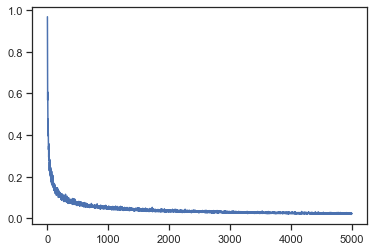

In [21]:
# 可視化
ax = sns.lineplot(x=list(range(1, max_dim+1)), y=dist_deltas)
plt.show() 

### Q4. 次元の呪い（2/2）（コサイン距離の平均値）
先の課題Qにおいて定義したN次元のユークリッド空間$R^n$において，ランダムに取得した50個の点間の**コサイン距離**の平均値を$dist_{avg}$，標準偏差を$dist_{std}$とする．

このユークリッド空間$R^n$の次元数を1から5000まで変化させたとき，$dist_{avg}$および$dist_{std}$の値がどのように変化するか，折れ線グラフで可視化せよ．また，高次元空間における点間の関係性を考察せよ．

In [22]:
dist_avgs = []
dist_stds = []
for dim_num in tqdm(range(1, max_dim+1)):
    max_dist = 2 * dim_num ** 0.5

    M = np.random.uniform(-1, 1, (element_num, dim_num))
    #dist_matrix = distance.cdist(M, M, metric='cosine')
    #avg_dist = np.triu(dist_matrix).sum() / comb(element_num, 2)    
    dists = distance.pdist(M, metric='cosine')
    dist_avg = np.mean(dists)
    dist_std = np.std(dists)  
    dist_avgs.append(dist_avg)    
    dist_stds.append(dist_std)

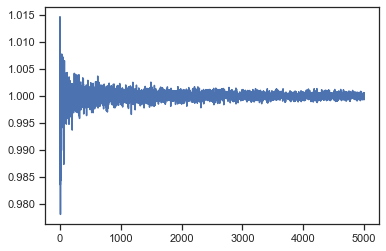

In [23]:
ax = sns.lineplot(x=list(range(1, max_dim+1)), y=dist_avgs)
plt.show() 

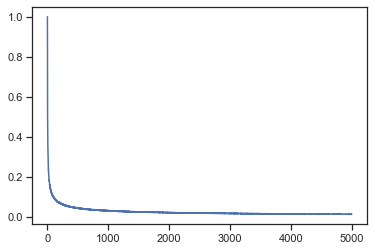

In [24]:
ax = sns.lineplot(x=list(range(1, max_dim+1)), y=dist_stds)
plt.show() 

### Q5. 多項式回帰（1/2）
``data/blobs``ディレクトリの``poly.tsv``には，変数$x$と$y$間の関係がある条件に従う2次元データが格納されている．下図は当該データの散布図である．2次元データの変数$x$と$y$の関係が$x$に関するN次関数（$y=w_d  x^d + w_{d-1}  x^{d-1}+ ... + w_1  x + w_0 $）で表されると仮定し，そのパラメータ（$\{w_d, w_{d-1}, ..., w_0\}$）を推定したい．

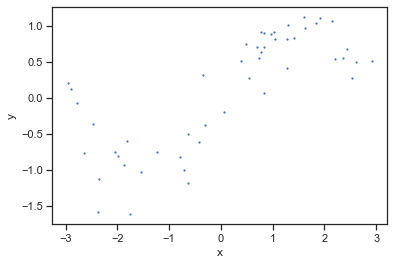

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style('ticks')
%matplotlib inline

df = pd.read_table('../data/blobs/poly.tsv', sep='\t', header=0)
X = df['x'].values.reshape(-1, 1)
y = df['y'].values.reshape(-1, 1)

fig = sns.scatterplot(x=X[:, 0], y=y[:, 0], linewidth=0, s=5)
fig.set_xlabel('x')
fig.set_ylabel('y')
plt.show()

2次元データの変数$x$と$y$の関係が$x$に関する3次関数（$y=w_3  x^3 + w_2  x^2 + w_1 x + w_0 $）で表されると仮定し，$x$から$y$を予測する回帰モデルを線形回帰によって構築せよ．また，5分割交差検証法によって，推定したモデルの平均絶対誤差（MAE）を求めよ．

なお，$x$のN次関数の線形回帰（多項式回帰）を行う前処理として，入力となるスカラーデータ$x$を$v_x=(x_1, x_2, ..., x_d)$のようなベクトルデータに拡張する必要がある．この処理は下記コードのように，``sklearn``の``PolynomialFeatures``クラスを用いることで行うことができる．

In [26]:
from sklearn.preprocessing import PolynomialFeatures as PF

X_sample = np.array([[1], [2], [3], [4]])

# xの3次多項式（3次関数用）に拡張
pf = PF(degree=3, include_bias=False)

X_sample_poly = pf.fit_transform(X_sample )
X_sample_poly

array([[ 1.,  1.,  1.],
       [ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

#### 解答

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

# 線形回帰
clf = LinearRegression()

# Cross Validation で検証する
degree = 3
k_fold = KFold(n_splits=5, shuffle=True, random_state=123)
score_funcs = {'MAE': 'neg_mean_absolute_error'}

pf = PF(degree=degree, include_bias=False)
X_poly = pf.fit_transform(X)
scores = cross_validate(clf, X_poly, y, cv=k_fold,
                        scoring=score_funcs, return_train_score=True)

MAE = -1 * np.mean(scores['test_MAE'])
MAE

0.24823507558422145

### Q6. 多項式回帰（2/2）：過学習
``data/blobs``ディレクトリの``poly.tsv``ファイルの2次元データについて，変数$x$と$y$の関係が$x$に関するN次関数で表されると仮定し，Nを1から30まで変化させて多項式回帰を行い，訓練データおよび評価データに対する平均絶対誤差を計算せよ．さらに，Nに対する平均絶対誤差の変化を訓練データ，評価データ別に折れ線グラフにプロットし，構築した回帰モデルの汎化性能について考察せよ．なお，性能評価には5分割交差検証法を用いよ．

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

# 線形回帰
clf = LinearRegression()

# Cross Validation で検証する
max_degree = 30
train_MAEs = []
test_MAEs = []
k_fold = KFold(n_splits=5, shuffle=True, random_state=123)
score_funcs = {'MAE': 'neg_mean_absolute_error'}

for degree in range(1, max_degree):
    pf = PF(degree=degree, include_bias=False)
    X_poly = pf.fit_transform(X)
    scores = cross_validate(clf, X_poly, y, cv=k_fold,
                            scoring=score_funcs, return_train_score=True)
    
    train_MAEs.append(-1 * np.mean(scores['train_MAE']))
    test_MAEs.append(-1 * np.mean(scores['test_MAE']))

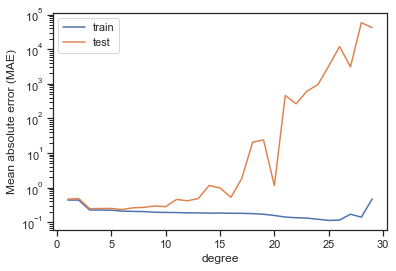

In [29]:
fig = sns.lineplot(x=list(range(1, max_degree)), y=train_MAEs)
sns.lineplot(x=list(range(1, max_degree)), y=test_MAEs)
fig.set(yscale="log", xlabel="degree", ylabel="Mean absolute error (MAE)")
fig.legend(['train', 'test'])
plt.show()

### Q7. 正則化（Embedding methodによる特徴量選択）
単純な線形回帰は，m次元のデータ$x \in R^m$と$y$の関係が$y=f(x)= w_1 x_1 + w_2 x_2 + .... + w_m x_m$ で表現されると仮定したときに，データセット$D =\{(x^i, y^i) | i=1,...n\} $に対して下記誤差関数を最小化するようなパラメータ$w = (w_1, w_2, ..., w_m)$を推定する．

$$
L = \frac{1}{n} \sum_{x \in X} (y - f(x))^2
$$

単純な線形回帰は，データの次元数（説明変数の数）が増えると過学習を起こしやすいという問題がある．

過学習を防ぐ方法の1つとして，学習するパラメータの値に制約を設ける**正則化**と呼ばれる方法がある．[Lasso回帰](https://ja.wikipedia.org/wiki/ラッソ回帰)は，誤差関数を最小化する代わりに，下記関数$L'$を最小化することでパラメータ$w$を学習する．

$$
L' = \frac{1}{n} \sum_{x \in X} (y - f(x))^2 + \lambda \sum_{i}^m |w_i|
$$

上記関数の値を最小化する結果として，Lasso回帰は予測に不要とされるパラメータがゼロになるという性質がある．

``data/blobs``ディレクトリの``poly.tsv``ファイル中に格納された2次元データについて，変数$x$と$y$の関係は$x$の10次関数として表されると仮定する．この仮定の上で，課題Q5のデータにLasso回帰を行い，$x$から$y$を予測する回帰モデルを構築せよ．また，構築した予測モデルを5分割交差検証法で評価せよ．また，構築された予測モデルのパラメータを確認し，選択された特徴量（重みがゼロでない特徴量）を調べよ．

なお，評価指標は平均絶対誤差とせよ．Lasso回帰には``sklearn``の``Lasso``クラスを用いよ．

In [30]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

# 線形回帰
clf = Lasso(max_iter=100000)

# Cross Validation で検証する
degree = 10
k_fold = KFold(n_splits=5, shuffle=True, random_state=123)
score_funcs = {'MAE': 'neg_mean_absolute_error'}

pf = PF(degree=degree, include_bias=False)
X_poly = pf.fit_transform(X)
scores = cross_validate(clf, X_poly, y, cv=k_fold,
                        scoring=score_funcs, 
                        return_train_score=True,
                        return_estimator=True)

MAE = -1 * np.mean(scores['test_MAE'])
MAE

0.6434874664446475

In [31]:
for estimator in scores['estimator']:
    print(estimator.coef_)

[ 0.         -0.          0.         -0.          0.0209609  -0.
 -0.         -0.00088492 -0.0002846   0.00010686]
[ 0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  2.68956681e-02 -0.00000000e+00  0.00000000e+00  6.16637570e-05
 -4.76638755e-04 -4.37410871e-05]
[ 0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  1.88040046e-02 -0.00000000e+00 -0.00000000e+00 -5.50145624e-04
 -2.55132650e-04  6.94413172e-05]
[ 0.          0.          0.         -0.          0.02269575 -0.
  0.         -0.00153058 -0.00032676  0.00018905]
[ 0.          0.          0.         -0.          0.02009838 -0.
  0.         -0.00105398 -0.00026939  0.000124  ]


### Q8. SVM回帰
Q5-Q7で用いた2次元データについてSVM回帰を行い，変数$x$から$y$を予測する回帰モデルを構築せよ．また，構築した予測モデルを5分割交差検証法で評価せよ．また，評価値が最も小さかったモデルについて，その回帰曲線をグラフにプロットせよ．

なお，評価指標は平均絶対誤差とせよ．Lasso回帰には``sklearn``の``Lasso``クラスを用いよ．また，グラフのX軸の範囲は$[-3, 3]$とせよ．

In [32]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

# SVM回帰
clf = SVR()

# Cross Validation で検証する
k_fold = KFold(n_splits=5, shuffle=True, random_state=123)
score_funcs = {'MAE': 'neg_mean_absolute_error'}

scores = cross_validate(clf, X, y[:, 0], cv=k_fold,
                        scoring=score_funcs, 
                        return_train_score=True,
                        return_estimator=True)

MAE = -1 * np.mean(scores['test_MAE'])
MAE

0.24608653517652704

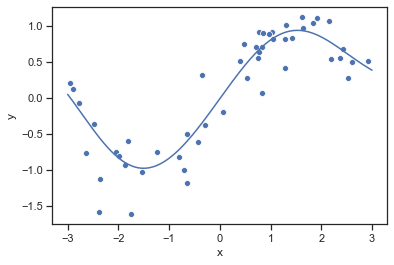

In [33]:
best_score = max(scores['test_MAE'])
best_model_idx = list(scores['test_MAE']).index(best_score)
best_regressor = scores['estimator'][best_model_idx]

X_plot = np.linspace(-3, 3, 10000).reshape(-1, 1)
y_plot = best_regressor.predict(X_plot)

fig = sns.scatterplot(X[:, 0], y[:, 0])
sns.lineplot(X_plot[:, 0], y_plot)
fig.set_xlabel('x')
fig.set_ylabel('y')
plt.show()

### Q9. 特徴量選択再訪（1/2）

[Madelon Dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/)には，ある規則によって人工的に生成されたデータである．当該データセットは2値分類問題用のデータセットであり，訓練用のデータセット（``madelon_train.xxx``）と評価用のデータセット（``madelon_valid.xxx``）が納められている．データセットは以下のファイルが含まれる．

* ``madelon_train.data``：500次元のデータが1500個納められたファイル（行が1データに対応．列はスペースで区切られている）
* ``madelon_train.labels``：``madelon_train.data``の各データに割り当てられたラベル（1もしくは-1）
* ``madelon_valid.data``：500次元のデータが500個納められたファイル（行が1データに対応．列はスペースで区切られている）
* ``madelon_valid.labels``：``madelon_valid.data``の各データに割り当てられたラベル（1もしくは-1）

Madelon Datasetの訓練データに対してRandom Forestを適用し，当該データに対するラベル分類器を構築せよ．また，構築した分類器と評価データを用いて，分類器の性能（F1値）を評価せよ．さらに，分類器に寄与した特徴量上位20件を求めよ．

In [34]:
X_train = pd.read_table('../data/madelon/madelon_train.data', sep=' ', header=None).drop(500, axis=1)
y_train = pd.read_table('../data/madelon/madelon_train.labels', sep=' ', header=None)

X_test = pd.read_table('../data/madelon/madelon_valid.data', sep=' ', header=None).drop(500, axis=1)
y_test = pd.read_table('../data/madelon/madelon_valid.labels', sep=' ', header=None)

X_train.shape

(2000, 500)

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

clf = RandomForestClassifier() 

clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
confusion_matrix(y_test, y_predicted)

<ipython-input-35-49206389fde0>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


array([[226,  74],
       [ 96, 204]])

In [36]:
print("F1 = ", f1_score(y_test, y_predicted))

F1 =  0.7058823529411765


In [37]:
# 特徴量の重要度情報を取得
feature_df = pd.DataFrame(clf.feature_importances_, columns=['importance']).sort_values('importance', ascending=False)


# 重要な特徴量の上位20件
important_features = list(feature_df[: 20].index)

### Q10. 特徴量選択再訪（2/2）
予測対象とは関係がない特徴量は，モデルの予測性能を低下させる可能性がある．そのため，前処理として特徴量選択が行われることがある．特徴量選択はモデルの予測性能の向上だけでなく，学習や予測にかかる時間の短縮や過学習対策に寄与する．

Q9で求めた重要度の高い特徴量上位20件のみを用いて，Madelon Datasetに対するラベル分類器を再度構築し，その分類性能（F1値）を求め，Q9の結果と比較せよ．

In [38]:
clf = RandomForestClassifier() 
clf.fit(X_train[important_features], y_train)

y_predicted = clf.predict(X_test[important_features])
confusion_matrix(y_test, y_predicted)

<ipython-input-38-de12e0a588ba>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train[important_features], y_train)


array([[268,  32],
       [ 32, 268]])

In [39]:
print("F1 = ", f1_score(y_test, y_predicted))

F1 =  0.8933333333333333


---
### 参考資料

* https://aotamasaki.hatenablog.com/entry/2019/01/05/195813
* https://www.haya-programming.com/entry/2019/11/07/202027